# Step 1: Business Problem :

### WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value

# Step 2: Transformed into Data Science Problem:

### There are four categories of sentiments through which we can analyse & predict sentiment of customers associated from Social Media :
    #0-Negative
    #1-Neutral
    #2-Positive
    #3-Unknown (can't tell)

# Exploratory Data Analysis (EDA):

### Importing necessary Libraries:

In [376]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from nltk.stem import WordNetLemmatizer
import re
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,cross_val_predict
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE


In [377]:
train=pd.read_csv("/Users/shilpyjain/Downloads/data/train.csv")

In [378]:
train.head(5)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [379]:
train.shape

(7274, 3)

In [380]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


In [381]:
# Define Utiliy Functions
def data_insights_report(data=pd.DataFrame()):
    report = pd.DataFrame()
    report['Columns'] = data.columns
    report['Data_Types'] = data.dtypes.values
    report['Unique_Count'] = data.nunique().values
    report['NAN_Count'] = data.isna().sum().values

    tempdf = data.describe().apply(lambda x: round(x,2), axis=1).T
    pd.merge(report,tempdf.reset_index().rename(columns={'index':'Columns'}), on='Columns')

    return report.join(tempdf, on='Columns')

In [382]:
data_insights_report(train)

,Columns,Data_Types,Unique_Count,NAN_Count,count,mean,std,min,25%,50%,75%,max
0,tweet_id,int64,7274,0,7274.0,4531.74,2617.86,2.0,2261.5,4530.5,6796.75,9092.0
1,tweet,object,7255,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sentiment,int64,4,0,7274.0,1.30,0.61,0.0,1.0,1.0,2.00,3.0


## 3.1 Checking target variable is balanced or imbalanced:

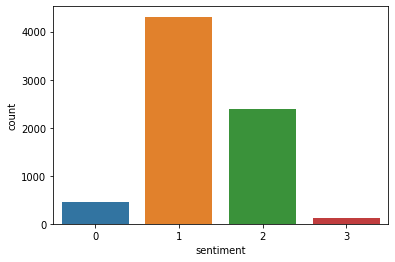

In [383]:
sns.countplot(train.sentiment)

In [384]:
round(train.sentiment.value_counts(normalize=True)*100,2)

1    59.27
2    32.75
0     6.27
3     1.72
Name: sentiment, dtype: float64

## Inference :
#Data is highly imbalanced as there is 60 % response is neutral(1) . 
#negative (0) & unknown (3) are significantly low values

## 3.2 tweet counts v/s Sentiment :

In [385]:
train2=train.copy()

In [386]:
len('tweet')

5

In [387]:
tweet_per_sentiment=train2.groupby(['sentiment'])['tweet'].count()

In [388]:
tweet_per_sentiment

sentiment
0     456
1    4310
2    2382
3     125
Name: tweet, dtype: int64

In [389]:
(tweet_per_sentiment/train2['tweet'].shape)*100

sentiment
0     6.268903
1    59.252131
2    32.746769
3     1.718449
Name: tweet, dtype: float64

Text(0, 0.5, 'Number of tweets')

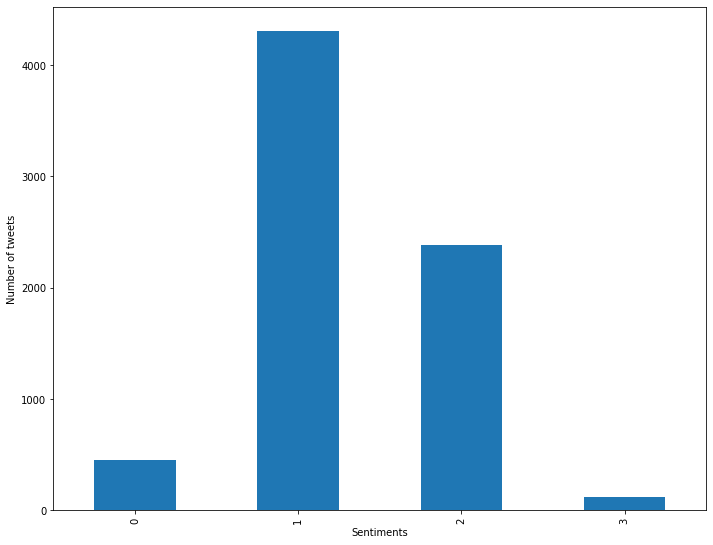

In [390]:
f, ax = plt.subplots(figsize=(11.7, 9.27))
tweet_per_sentiment.plot.bar()
plt.xlabel("Sentiments")
plt.ylabel("Number of tweets")


### Inference :
#There are 4310 tweets out of 7255 are only associated with Neutral(1) response
#There are 456 & 125 are associated with negative (0) & unknown(3)
#There are 2382 tweets associated with Positive(2)

## 3.3 Checking Null values:

In [391]:
null_columns=train2.columns[train2.isnull().any()]
train2[null_columns].isnull().sum()

tweet    1
dtype: int64

In [392]:
#to check single null column:
print(train2[train2["tweet"].isnull()][null_columns])

     tweet
1274   NaN


In [393]:
#if you want to check all null columns :
print(train2[train2.isnull().any(axis=1)][null_columns].head())

     tweet
1274   NaN


In [394]:
train2[train2['tweet_id']==6]

,tweet_id,tweet,sentiment
1274,6,NaN,1


### Inference :
There is only one null tweet in full dataset with tweet id :6 and it has sentiment neutral(1)

## 3.4 : Checking Duplicate tweets : (not in lower case)

In [395]:
dup_tweets=train2[train2['tweet'].duplicated()]

In [396]:
dup_tweets

,tweet_id,tweet,sentiment
1473,6300,RT @mention Marissa Mayer: Google Will Connect...,1
1832,6298,RT @mention Marissa Mayer: Google Will Connect...,2
2039,5880,RT @mention Google to Launch Major New Social ...,1
2165,3813,Win free ipad 2 from webdoc.com #sxsw RT,2
2823,6293,RT @mention Marissa Mayer: Google Will Connect...,2
2855,6294,RT @mention Marissa Mayer: Google Will Connect...,1
3194,5881,RT @mention Google to Launch Major New Social ...,1
3267,3814,Win free iPad 2 from webdoc.com #sxsw RT,2
3867,6296,RT @mention Marissa Mayer: Google Will Connect...,2
4180,5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",1


In [397]:
len(dup_tweets)

18

In [398]:
dup_tweets.tweet.nunique()

12

### Inference :
#There are some duplicate records which have different sentiment scores 
#so we need to take care of theses records it may create wrong results

![title](Desktop/img.png)

## 3.5 : Create A word Cloud for each sentiment :

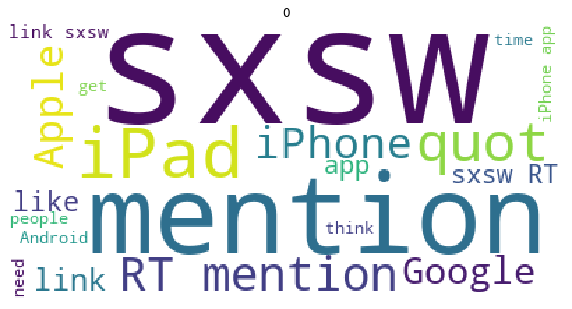

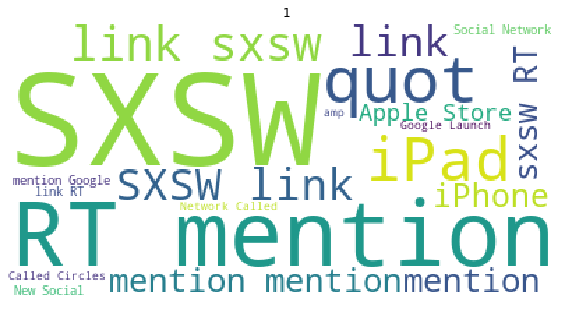

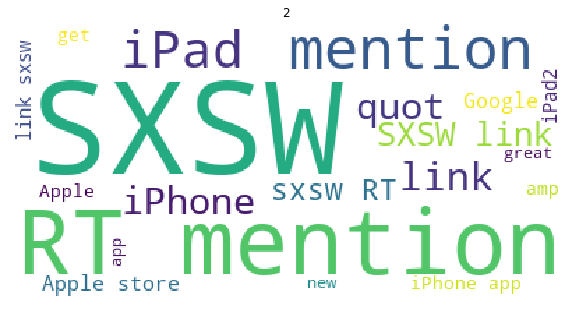

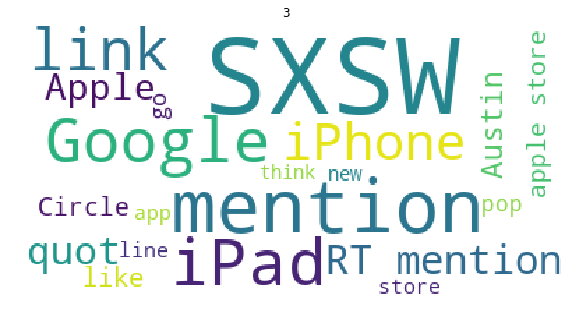

In [399]:
sentiments = [0, 1, 2, 3]
cloud = WordCloud(background_color="white", max_words=20, stopwords=stopwords.words('english'))
def draw_word_clouds(dataframe):
    for i in sentiments:
        category = cloud.generate(dataframe.loc[dataframe['sentiment'] == i, 'tweet'].str.cat(sep='\n'))
        plt.figure(figsize=(10,10))
        plt.imshow(category)
        plt.axis("off")
        plt.title(i)
        plt.show()
draw_word_clouds(train2)

### Inference :
Some words are common in all like : sxsw,mention,ipad,iphone,google (most common words)

# Step 4 : Basic Feature Extraction :

### Basic feature extraction using text data:
#Number of uppercase words
#Number of words
#Number of characters
#Average word length
#Number of stopwords
#Number of special characters : # , @mention ,RT
#Number of numerics
#Number of nouns
#number of verbs
#number of adjectives


## 4.1 Number of words in uppercase in tweets. & their impact on sentiment :

In [400]:
train2['upper'] = train2['tweet'].apply(lambda x: len([str(x) for x in str(x).split() if str(x).isupper()]))
train2[['tweet','upper']].head()

,tweet,upper
0,#sxswnui #sxsw #apple defining language of tou...,0
1,Learning ab Google doodles! All doodles should...,0
2,one of the most in-your-face ex. of stealing t...,2
3,This iPhone #SXSW app would b pretty awesome i...,1
4,Line outside the Apple store in Austin waiting...,1


### Impact of uppercase words on Sentiment :

In [401]:
upper_sentiment=round((train2['upper'].groupby(train2['sentiment']).mean()),1)
print(upper_sentiment)

sentiment
0    1.1
1    1.2
2    1.2
3    1.2
Name: upper, dtype: float64


Text(0, 0.5, 'Average uppercase word count')

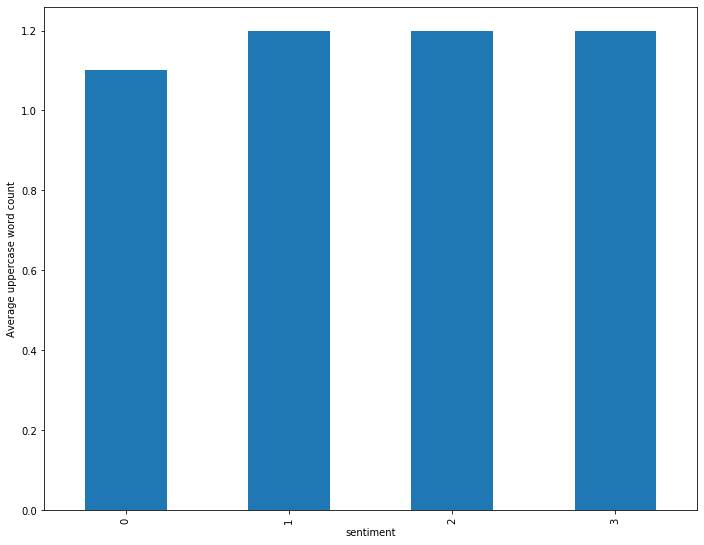

In [402]:
f, ax = plt.subplots(figsize=(11.7, 9.27))
upper_sentiment.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average uppercase word count")

### Inference :
almost same number of Uppercase words has been used in all tweets according to respective sentiments

## Extraction Of Emoji/emoticons from tweet :

In [403]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)',';-)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [404]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [405]:
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [406]:
import emoji
import re
import string

def extract_emoji(text):

    emoji_list = []
    text=text.replace(".","")
    word_split = text.split(" ")
    for w in word_split:
        if w  in emoticons and w not in string.punctuation:
            emoji_list.append(w)
            print(emoji_list,text)
            return ' '.join(emoji_list)

In [407]:
emo_list=train2['tweet'].map(lambda x: extract_emoji(str(x)))

[':)'] RT @mention Any iPAD2's left at the Apple store at #SXSW? Anyone know? :)
[':)'] Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw
[';-)'] Photo: By far, the best #sxsw accessory is an ipad Followed closely by a margarita ;-) {link}
[':)'] @mention Hey Mark, no sleep for you at #sxsw! Bring me home a shiny new iPad, would ya? :) @mention
[':('] I won an iPad at #SXSW! Nah I'm lying, I bought this shit myself :( {link}
[':)'] Getting hip to new Android apps in preparation for #Hangover3, also known as #SXSW @mention @mention and @mention apps rock my socks :)
[':P'] RT @mention Microsoft to launch IE9 at #SXSW: {link} Here you go @mention Maybe you can get MS to install on the  ipad :P
[';)'] Props to GSDM and the big G (google) at #SXSW Great crowd and agency space but Bluezoom can give them a run ;) {link}
[':)'] @mention yay :) thank you! what do you do? #pushio #sxsw #ipad
[':('] shoot, my ipad will 

In [408]:
emo_list.unique()

array([None, ':)', ';-)', ':(', ':P', ';)', ':-(', ':-)', ':D', ':-/',
       ':p', '=)', 'xD', ':]', ':-D', '=D', 'XD'], dtype=object)

## 4.2 Change all tweets into lowercase :

In [409]:
train2['tweet'] = train2['tweet'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
train2['tweet'].head()

0    #sxswnui #sxsw #apple defining language of tou...
1    learning ab google doodles! all doodles should...
2    one of the most in-your-face ex. of stealing t...
3    this iphone #sxsw app would b pretty awesome i...
4    line outside the apple store in austin waiting...
Name: tweet, dtype: object

### Impact of LOWERCASE TWEETS on duplicate Records :

In [410]:
dup_tweets_lower=train2[train2['tweet'].duplicated()]

In [411]:
len(dup_tweets_lower)

53

In [412]:
dup_tweets_lower.tweet.nunique()

35

In [413]:
train2[train2[['tweet','sentiment']].duplicated()==True].sort_values('tweet_id')

,tweet_id,tweet,sentiment,upper
5821,17,i just noticed dst is coming this weekend. how...,0,4
5490,20,need to buy an ipad2 while i'm in austin at #s...,2,1
6193,458,@mention enjoy #sxsw and ride anywhere in aust...,1,0
3250,466,"before it even begins, apple wins #sxsw {link}",2,1
4334,468,"before it even begins, apple wins #sxsw {link}",2,1
2391,776,google to launch major new social network call...,1,0
4435,798,google to launch major new social network call...,1,0
1229,812,google to launch major new social network call...,2,0
2560,2230,marissa mayer: google will connect the digital...,1,0
5130,2232,marissa mayer: google will connect the digital...,1,0


### Inference :
#After converting all texts into lowercase , duplicate records got increased from 12 to 35 (unique ones)
#Some exactly similar records have two different sentiment values in (neutral(1),positive(2))

## 4.3: Number of words per tweet & its impact on sentiment column :

In [414]:
train2['word_count'] = train2['tweet'].apply(lambda x: len(str(x).split(" ")))
train2[['tweet','word_count']].head()

,tweet,word_count
0,#sxswnui #sxsw #apple defining language of tou...,12
1,learning ab google doodles! all doodles should...,19
2,one of the most in-your-face ex. of stealing t...,22
3,this iphone #sxsw app would b pretty awesome i...,19
4,line outside the apple store in austin waiting...,14


### impact on sentiment column :

In [415]:
word_sentiment=(train2['word_count'].groupby(train2['sentiment']).mean())
print(word_sentiment)

sentiment
0    18.684211
1    17.382278
2    18.220823
3    17.488000
Name: word_count, dtype: float64


Text(0, 0.5, 'Average Word count')

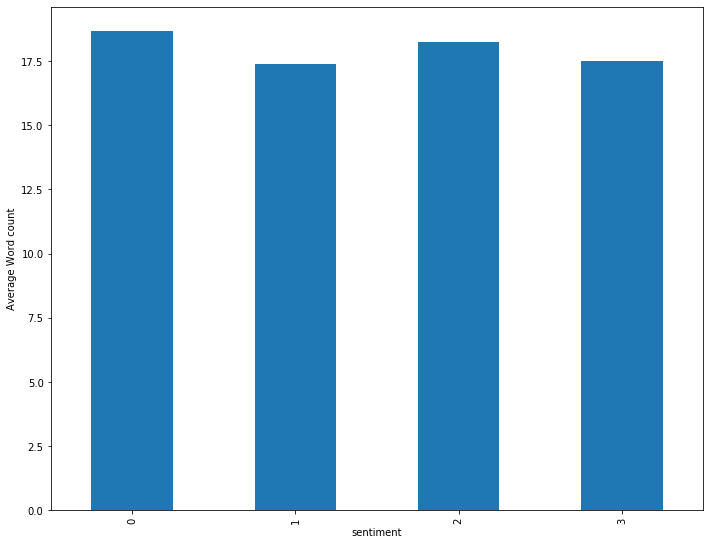

In [416]:
f, ax = plt.subplots(figsize=(11.7, 9.27))
word_sentiment.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average Word count")

### Inference :
#There is no such impact on sentiment column.
#there is number of words are more in Negative tweet(0)
#Average number of words respective to all sentiments are moreover same 

## 4.4 Number of characters per tweet & impact on sentiment analysis :

In [417]:
train2['char_count'] = train2['tweet'].str.len() ## this also includes spaces

In [418]:
train2[['tweet','char_count']].head(3)

,tweet,char_count
0,#sxswnui #sxsw #apple defining language of tou...,89
1,learning ab google doodles! all doodles should...,143
2,one of the most in-your-face ex. of stealing t...,131


### Impact on sentiment column :

In [419]:
char_sentiment=(train2['char_count'].groupby(train2['sentiment']).mean())
print(char_sentiment)

sentiment
0    108.754386
1    103.790072
2    105.651134
3    101.584000
Name: char_count, dtype: float64


Text(0, 0.5, 'Average Character count')

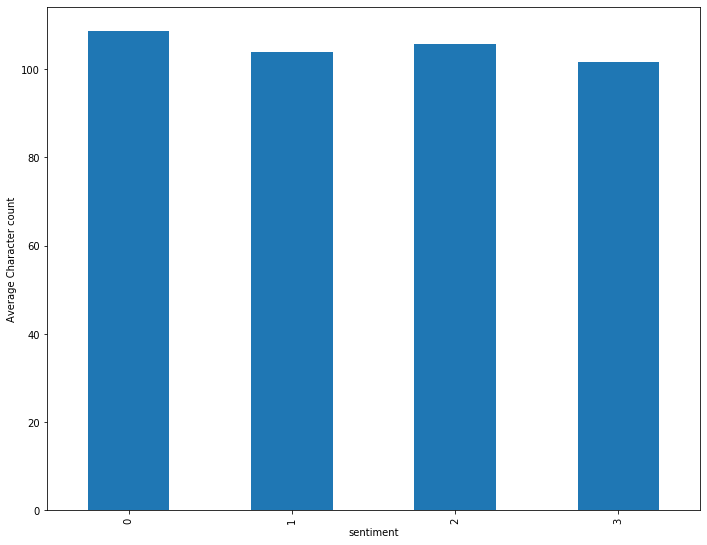

In [420]:
 ax = plt.subplots(figsize=(11.7, 9.27))
char_sentiment.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average Character count")

### Inference :
Character count is more in case of negative sentiment (0)


## 4.5 Average word Length & impact on Sentiment :

In [421]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train2['avg_word'] = train2['tweet'].apply(lambda x: avg_word(x))
train2[['tweet','avg_word']].head()

,tweet,avg_word
0,#sxswnui #sxsw #apple defining language of tou...,6.500000
1,learning ab google doodles! all doodles should...,6.578947
2,one of the most in-your-face ex. of stealing t...,5.000000
3,this iphone #sxsw app would b pretty awesome i...,5.631579
4,line outside the apple store in austin waiting...,4.500000


### Impact of average word length on Sentiment :

In [422]:
avgword_sentiment=(train2['avg_word'].groupby(train2['sentiment']).mean())
print(avgword_sentiment)

sentiment
0    4.950472
1    5.115381
2    4.922710
3    4.933317
Name: avg_word, dtype: float64


Text(0, 0.5, 'Average word length')

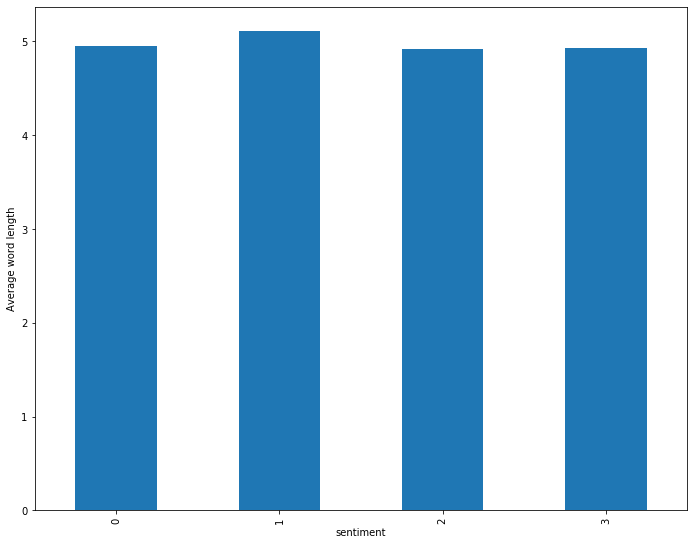

In [423]:
ax = plt.subplots(figsize=(11.7, 9.27))
avgword_sentiment.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average word length")

### Inference :
Its almost same in all tweets respective to sentiments.

## 4.6 :Number of stop words per tweet & Their imapct on Sentiment :

In [424]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train2['stopwords'] = train2['tweet'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
train2[['tweet','stopwords']].head()

,tweet,stopwords
0,#sxswnui #sxsw #apple defining language of tou...,2
1,learning ab google doodles! all doodles should...,5
2,one of the most in-your-face ex. of stealing t...,7
3,this iphone #sxsw app would b pretty awesome i...,5
4,line outside the apple store in austin waiting...,4


### Impact of stopwords on Sentiment :

In [425]:
avg_stop_sentiment=(train2['stopwords'].groupby(train2['sentiment']).mean())
print(avg_stop_sentiment)

sentiment
0    6.179825
1    4.760148
2    5.397565
3    5.568000
Name: stopwords, dtype: float64


Text(0, 0.5, 'Average Stopwords count')

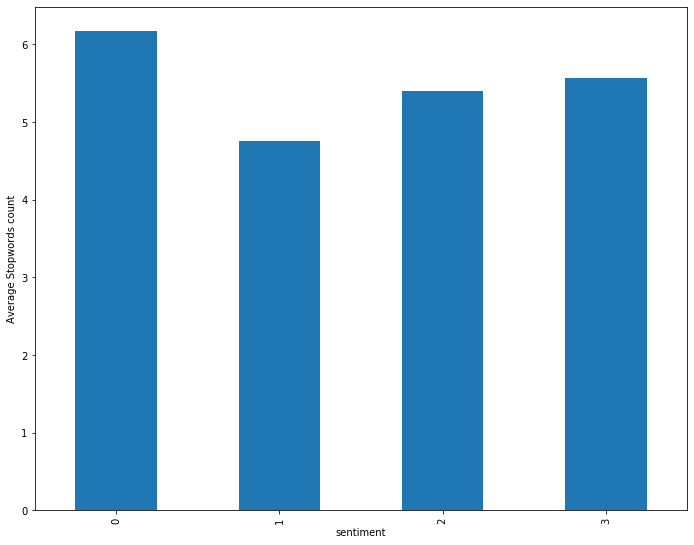

In [426]:
ax = plt.subplots(figsize=(11.7, 9.27))
avg_stop_sentiment.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average Stopwords count")

### Inference:
Neutal(1) sentiment has lesser stopwords as compared to other sentiment tweets 

## 4.7: Number of special characters & their respective impact on Sentiment :

In [427]:
def preprocess(s):
    lower_ls=nltk.word_tokenize(s.lower())
    return lower_ls

In [428]:
lower_ls=train2['tweet'].map(lambda x: preprocess(str(x)))

### 4.7.1 : Number of Hashtags # & their impact on Sentiment :

In [429]:
train2['hashtag_cnt']=lower_ls.map(lambda x: x.count('#'))

In [430]:
train2[['tweet','hashtag_cnt']].head()

,tweet,hashtag_cnt
0,#sxswnui #sxsw #apple defining language of tou...,3
1,learning ab google doodles! all doodles should...,2
2,one of the most in-your-face ex. of stealing t...,1
3,this iphone #sxsw app would b pretty awesome i...,3
4,line outside the apple store in austin waiting...,1


In [431]:
train2['hashtag_cnt'].sum()

12685

In [432]:
avg_hashtag_tweet=(train2['hashtag_cnt'].groupby(train2['sentiment']).mean())
print(avg_hashtag_tweet)

sentiment
0    1.607456
1    1.794711
2    1.685558
3    1.600000
Name: hashtag_cnt, dtype: float64


Text(0, 0.5, 'Average hashtag count')

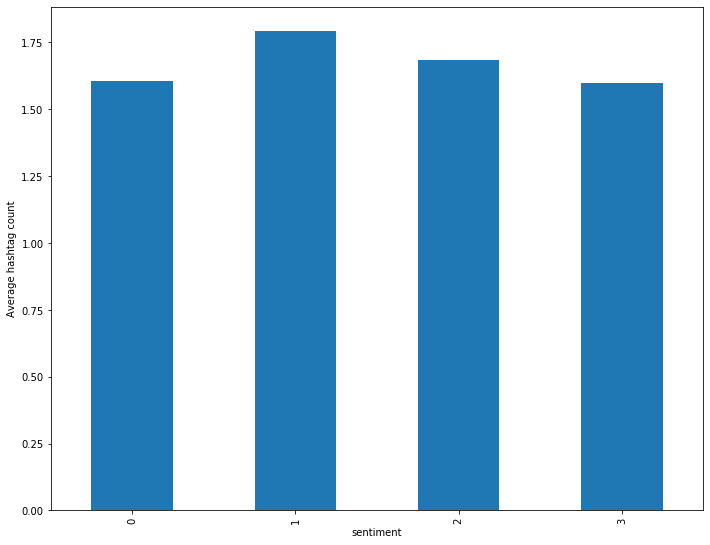

In [433]:
ax = plt.subplots(figsize=(11.7, 9.27))
avg_hashtag_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Average hashtag count")

### Inference:
Its almost same in all tweets respective to sentiments.

In [434]:
hashtag_count_tweet=(train2['hashtag_cnt'].groupby(train2['sentiment']).sum())
print(hashtag_count_tweet)

sentiment
0     733
1    7737
2    4015
3     200
Name: hashtag_cnt, dtype: int64


In [435]:
(train2['hashtag_cnt']).sum()

12685

Text(0, 0.5, 'Total hashtag count')

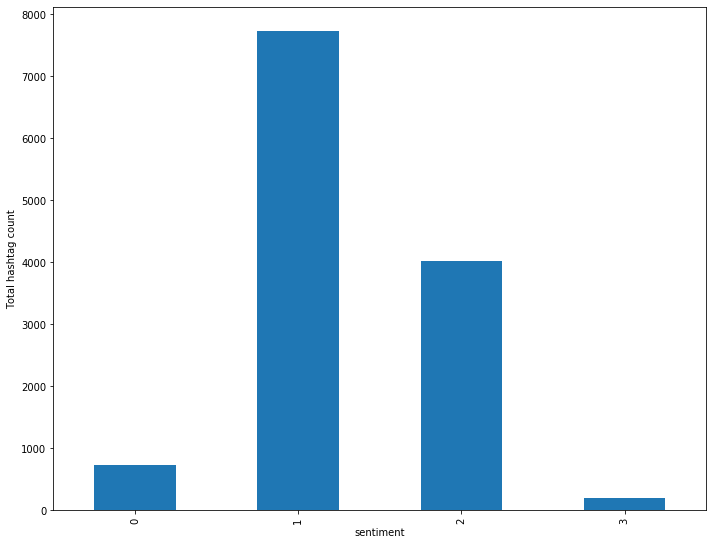

In [436]:
ax = plt.subplots(figsize=(11.7, 9.27))
hashtag_count_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total hashtag count")

### Inference :
#Total Hashtags used are 12685
#Mostly Hashtags are used in Neutral (1) Sentiment around 7737
#In Negative(0) are comparitavley less hashtags 733

### Extraction of Hashtags & check which hashtag has more impact on respective Sentiment :


In [437]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

### Hashtags used in tweets respective to Sentiment: Negative(0)

In [438]:
HT_negative = hashtag_extract(train2['tweet'][train2['sentiment'] == 0])

In [439]:
len(HT_negative) # total number of hashtags

456

In [442]:
print(len(set
          (HT_negative)))  # Unique hashtags present in Negative (0) sentiment

150


In [441]:
#unnesting the list :
HT_negative = sum(HT_negative,[])

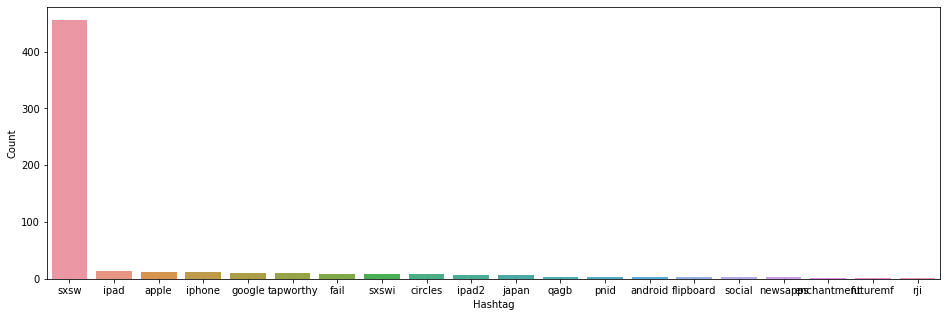

In [443]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Inference :
#sxsw is the most used hashtag in Negative (0) sentiment as compared to other 149 hashtags 
#It has been used 450 times 

### Hashtags used in tweets respective to Sentiment: Neutral(1)

In [444]:
HT_neutral = hashtag_extract(train2['tweet'][train2['sentiment'] == 1])

In [445]:
len(HT_neutral) # total number of hashtags

4311

In [448]:
print(len(set(HT_neutral)))  # Unique hashtags present in Neutral (1) sentiment

953


In [447]:
#unnesting the list :
HT_neutral = sum(HT_neutral,[])

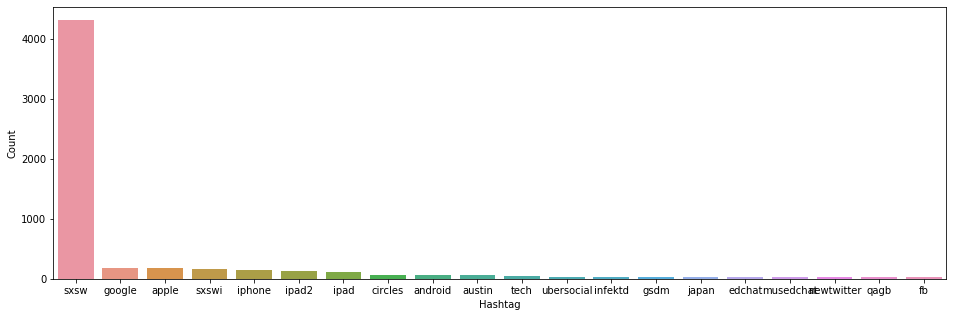

In [449]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Inference :
sxsw is the most used hashtag in Neutral (1) sentiment as compared to other 952 hashtags

### Hashtags used in tweets respective to Sentiment: Positive(1)

In [450]:
HT_positive = hashtag_extract(train2['tweet'][train2['sentiment'] == 2])

In [451]:
#unnesting the list :
HT_positive = sum(HT_positive,[])

In [452]:
len(HT_positive) # total number of hashtags

4009

In [453]:
print(len(set(HT_positive)))  # Unique hashtags present in Negative (0) sentiment

550


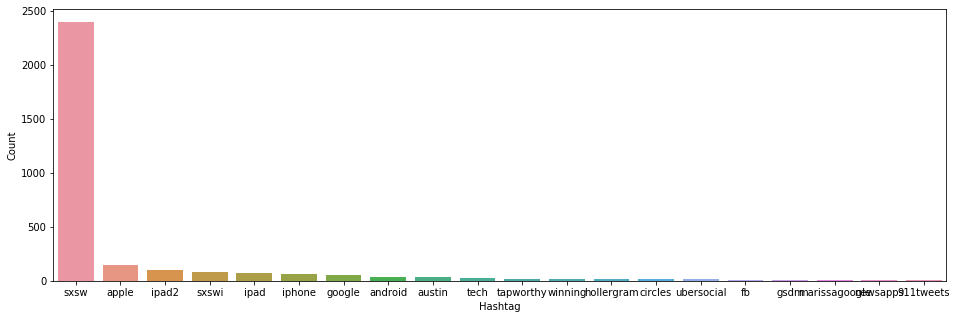

In [454]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Inference:
sxsw is the most used hashtag in positive (2) sentiment as compared to other 549 hashtags

### 4.7.2 : Number of  @ & their impact on Sentiment :

In [455]:
train2['mention_cnt']=lower_ls.map(lambda x: x.count('@'))

In [456]:
train2[['tweet','mention_cnt']].head()

,tweet,mention_cnt
0,#sxswnui #sxsw #apple defining language of tou...,0
1,learning ab google doodles! all doodles should...,0
2,one of the most in-your-face ex. of stealing t...,1
3,this iphone #sxsw app would b pretty awesome i...,0
4,line outside the apple store in austin waiting...,0


In [457]:
len(train2['mention_cnt'])

7274

In [458]:
mention_count_tweet=(train2['mention_cnt'].groupby(train2['sentiment']).sum())
print(mention_count_tweet)

sentiment
0     252
1    3667
2    1763
3      80
Name: mention_cnt, dtype: int64


Text(0, 0.5, 'Total @ used (sum)')

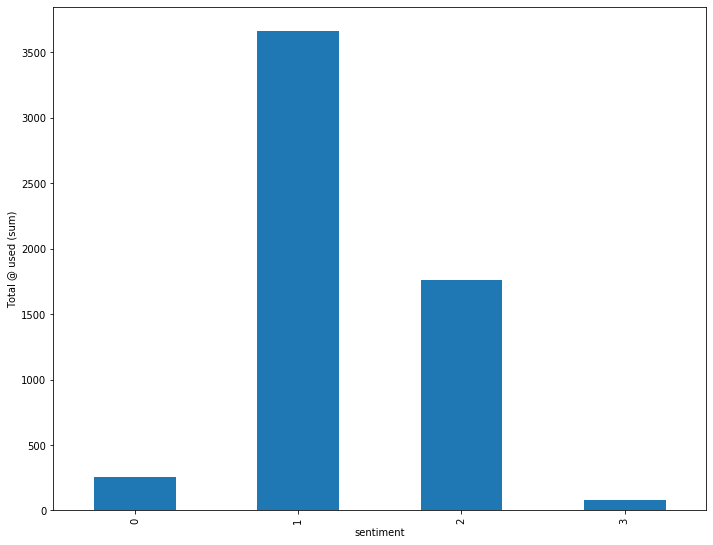

In [459]:
ax = plt.subplots(figsize=(11.7, 9.27))
mention_count_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total @ used (sum)")

### Inference :
Mostly @mentions are used in Neutral(1) and then in Positive(2)

### 4.7.3 : Number of RT & their impact on Sentiment :

In [460]:
train2['rt_cnt']=lower_ls.map(lambda x: x.count('rt'))

In [461]:
len(train2['rt_cnt'])

7274

In [462]:
rt_count_tweet=(train2['rt_cnt'].groupby(train2['sentiment']).sum())
print(rt_count_tweet)

sentiment
0     108
1    1466
2     768
3      27
Name: rt_cnt, dtype: int64


Text(0, 0.5, 'Total number of RT used(sum)')

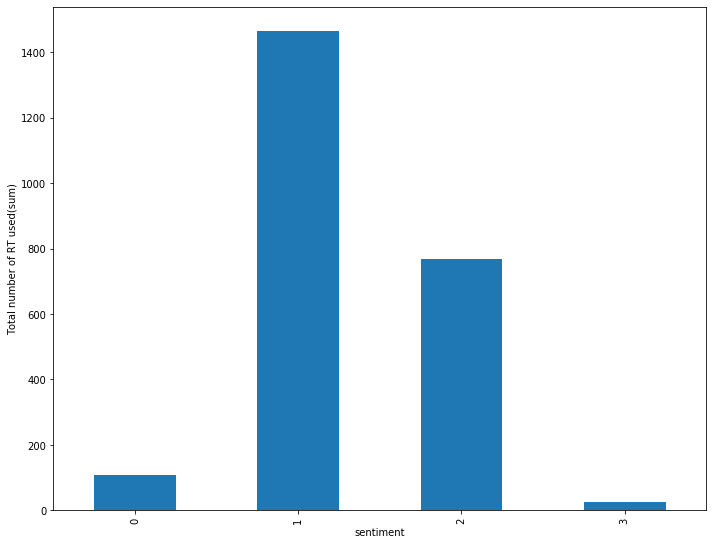

In [463]:
ax = plt.subplots(figsize=(11.7, 9.27))
rt_count_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total number of RT used(sum)")

### Inference:
Mostly @mentions are used in Neutral(1) and then in Positive(2)

## 4.8 Number of numerics & its impact on Sentiment :

In [464]:
train2['numerics'] = train2['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train2[['tweet','numerics']].head()

,tweet,numerics
0,#sxswnui #sxsw #apple defining language of tou...,0
1,learning ab google doodles! all doodles should...,0
2,one of the most in-your-face ex. of stealing t...,0
3,this iphone #sxsw app would b pretty awesome i...,0
4,line outside the apple store in austin waiting...,0


In [465]:
train2['numerics'].unique()

array([0, 1, 2, 3, 5])

In [466]:
train2['numerics'].nunique()

5

In [467]:
len(train2['numerics'])

7274

In [468]:
mask = train2['numerics'].where(train2['numerics']!=0)

In [469]:
mask.unique()

array([nan,  1.,  2.,  3.,  5.])

In [470]:
num_count_tweet=(mask.groupby(train2['sentiment']).count())
print(num_count_tweet)

sentiment
0     57
1    628
2    398
3     18
Name: numerics, dtype: int64


Text(0, 0.5, 'Total numerics count (numerics=1,2,3,5)')

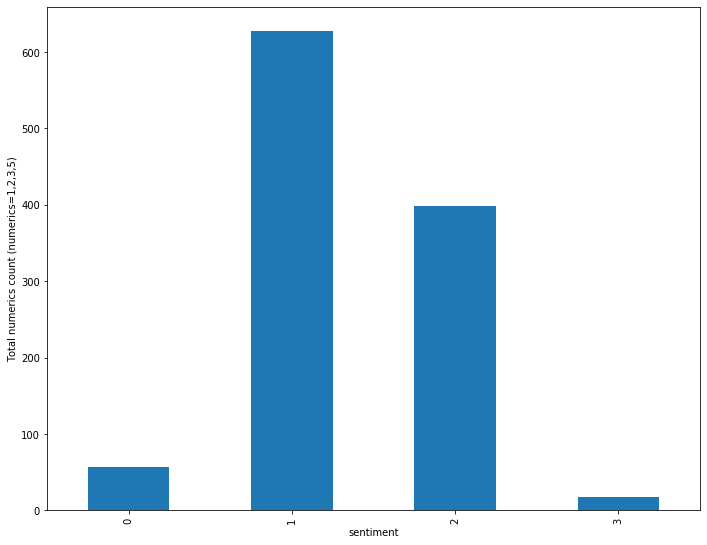

In [471]:
ax = plt.subplots(figsize=(11.7, 9.27))
num_count_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total numerics count (numerics=1,2,3,5)")

In [472]:
train2.pivot_table(index='sentiment', columns=train2['numerics'].where(train2['numerics']!=0), aggfunc={'numerics':len}, fill_value=0)

numerics            
numerics       1.0 2.0 3.0 5.0
sentiment                     
0               52   4   1   0
1              568  51   8   1
2              361  31   6   0
3               14   4   0   0

### Inference:
#Neutral(1) has maximum numerics count=628
#Positive (2) has numeric count=398
#we can consider it like rating as values are between (1(poor),2(average),3(good) & 5(perfect))


## 4.9 Number of nouns & its impact on Sentiment:

In [473]:
tweet_ls = train2['tweet'].apply(lambda x: str(x).split())
nouns_ls=tweet_ls.apply(lambda x: [i[0] for i in nltk.pos_tag(x) if i[1] in ['NN','NNS','NNP','NNPS']])
train2['nouns']=nouns_ls.map(lambda x: len(x))

In [474]:
noun_mean_tweet=(train2['nouns'].groupby(train2['sentiment']).mean())
print(noun_mean_tweet)

sentiment
0    7.289474
1    7.900255
2    7.823678
3    7.432000
Name: nouns, dtype: float64


In [475]:
noun_percentage_tweet=((train2['nouns'].groupby(train2['sentiment']).sum())/train2['nouns'].sum())*100
print(noun_percentage_tweet)

sentiment
0     5.837006
1    59.806487
2    32.725166
3     1.631341
Name: nouns, dtype: float64


In [476]:
noun_sum_tweet=(train2['nouns'].groupby(train2['sentiment']).sum())
print(noun_sum_tweet)

sentiment
0     3324
1    34058
2    18636
3      929
Name: nouns, dtype: int64


In [477]:
noun_sum_tweet.sum()

56947

Text(0, 0.5, 'Total nouns  (sum)')

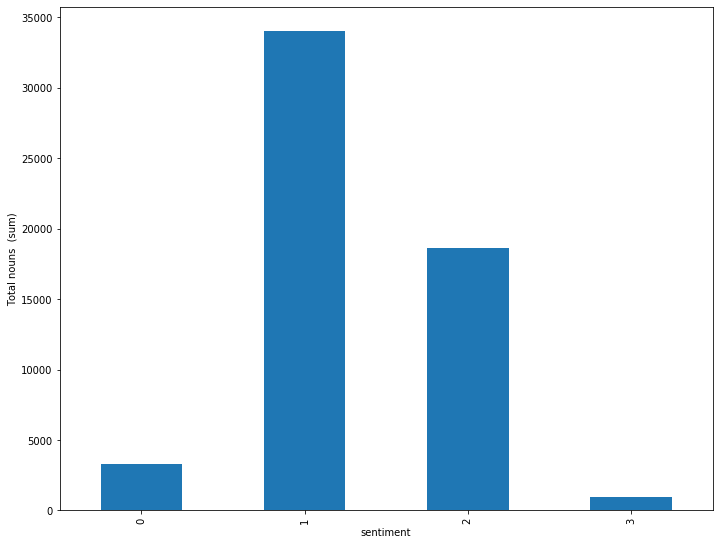

In [478]:
ax = plt.subplots(figsize=(11.7, 9.27))
noun_sum_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total nouns  (sum)")

## 4.10 Number of verbs & their impact on sentiment :


In [479]:
verb_ls=tweet_ls.apply(lambda x: [i[0] for i in nltk.pos_tag(x) if i[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']])
train2['verbs']=verb_ls.map(lambda x: len(x))

In [480]:
verb_mean_tweet=(train2['verbs'].groupby(train2['sentiment']).mean())
print(verb_mean_tweet)

sentiment
0    3.094298
1    2.399675
2    2.582284
3    2.584000
Name: verbs, dtype: float64


In [481]:
verb_percentage_tweet=((train2['verbs'].groupby(train2['sentiment']).sum())/train2['verbs'].sum())*100
print(verb_percentage_tweet)

sentiment
0     7.739989
1    56.747120
2    33.741086
3     1.771805
Name: verbs, dtype: float64


In [482]:
verb_sum_tweet=(train2['verbs'].groupby(train2['sentiment']).sum())
print(verb_sum_tweet)

sentiment
0     1411
1    10345
2     6151
3      323
Name: verbs, dtype: int64


In [483]:
verb_sum_tweet.sum()

18230

Text(0, 0.5, 'Total verbs  (sum)')

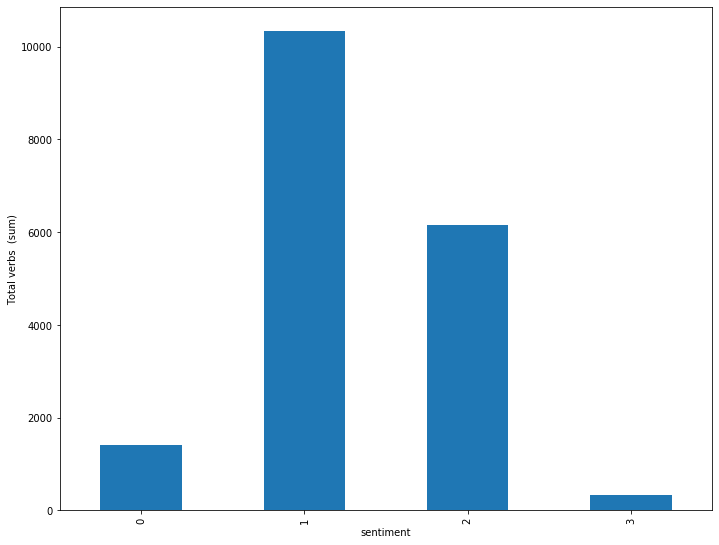

In [484]:
ax = plt.subplots(figsize=(11.7, 9.27))
verb_sum_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total verbs  (sum)")

## 4.11 Number of adjectives & their impact on sentiments :

In [485]:
adj_ls=tweet_ls.apply(lambda x: [i[0] for i in nltk.pos_tag(x) if i[1] in ['JJ','JJR','JJS']])
train2['adjectives']=adj_ls.map(lambda x: len(x))

In [486]:
adj_mean_tweet=(train2['adjectives'].groupby(train2['sentiment']).mean())
print(adj_mean_tweet)

sentiment
0    1.984649
1    1.887497
2    2.028547
3    1.712000
Name: adjectives, dtype: float64


In [487]:
adj_percentage_tweet=((train2['adjectives'].groupby(train2['sentiment']).sum())/train2['adjectives'].sum())*100
print(adj_percentage_tweet)

sentiment
0     6.423907
1    57.758376
2    34.298694
3     1.519023
Name: adjectives, dtype: float64


In [488]:
adj_sum_tweet=(train2['adjectives'].groupby(train2['sentiment']).sum())
print(adj_sum_tweet)

sentiment
0     905
1    8137
2    4832
3     214
Name: adjectives, dtype: int64


In [489]:
adj_sum_tweet.sum()

14088

Text(0, 0.5, 'Total adjectives  (sum)')

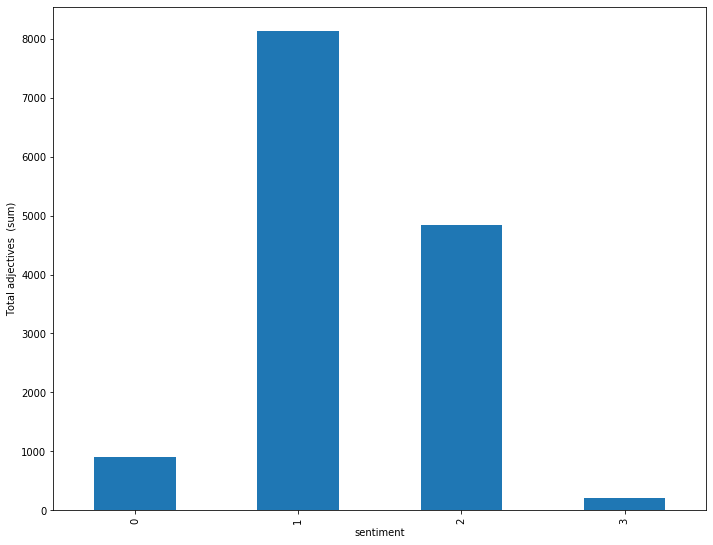

In [490]:
ax = plt.subplots(figsize=(11.7, 9.27))
adj_sum_tweet.plot.bar()
plt.xlabel("sentiment")
plt.ylabel("Total adjectives  (sum)")

## Step 5 : Basic Text Pre Processing :

### Basic Text Pre-processing of text data:
Transforming emoticons into "happy" & "sad " in original tweet
#Punctuation removal
#Stopwords removal
#Frequent words removal
#Rare words removal
#consecutive non ascii characters
#Stemming
#Lemmatization

In [ ]:
pip install emoji

## 5.1 Transforming Emoticons into "happy" & "sad":

In [586]:
def replace_emoji(text):
    emoji_ls_happy = []
    emoji_ls_sad = []
    text=text.replace(".","")
    word_split = text.split(" ")
    for w in word_split:
        if w in emoticons_happy and w not in string.punctuation:
            emoji_ls_happy.append(w)
        if w in emoticons_sad and w not in string.punctuation:
            emoji_ls_sad.append(w)
    if len(emoji_ls_happy) != 0:
        for i in emoji_ls_happy:
            text=text.replace(i,"happy")
    if len(emoji_ls_sad) != 0:
        for i in emoji_ls_sad:
            text=text.replace(i,"sad")
    return text
#train['tweet_emo']=train['tweet'].map(lambda x: replace_emoji(str(x)))

In [587]:
train2['tweet']=train2['tweet'].map(lambda x: replace_emoji(str(x)))

## 5.2 : Removal of Punctuations :

In [588]:
train2['clean_tweet'] = train2['tweet'].str.replace('[^\w\s]','')
train2['clean_tweet'].head()

0    sxswnui sxsw apple defining language of touch ...
1    learning ab google doodles all doodles should ...
2    one of the most inyourface ex of stealing the ...
3    this iphone sxsw app would b pretty awesome if...
4    line outside the apple store in austin waiting...
Name: clean_tweet, dtype: object

### Inference :
#we have removed punctuation, as it doesn’t add any extra information while treating text data. 
#Therefore removing all instances of it will help us reduce the size of the training data.
#all the punctuation, including ‘#’ and ‘@’, has been removed from the training data.

## 5.3: Removal of StopWords:

In [589]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train2['clean_tweet'] = train2['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train2['clean_tweet'].head()

0    sxswnui sxsw apple defining language touch dif...
1    learning ab google doodles doodles light funny...
2    one inyourface ex stealing show yrs rt mention...
3    iphone sxsw app would b pretty awesome didnt c...
4    line outside apple store austin waiting new ip...
Name: clean_tweet, dtype: object

## 5.4: Removal of Common/frequent Words:

In [590]:
freq = pd.Series(' '.join(train2['clean_tweet']).split()).value_counts()[:10]

In [591]:
print(freq)

sxsw       7540
mention    5512
link       3427
rt         2344
ipad       1912
google     1862
apple      1729
iphone     1215
store      1188
new         862
dtype: int64


In [592]:
#Now, let’s remove these words as their presence will not of any use in classification of our text data.
freq = list(freq.index)
train2['clean_tweet'] = train2['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train2['clean_tweet'].head()

0    sxswnui defining language touch different dial...
1    learning ab doodles doodles light funny amp in...
2    one inyourface ex stealing show yrs quotat sch...
3    app would b pretty awesome didnt crash every 1...
4                          line outside austin waiting
Name: clean_tweet, dtype: object

### Inference :
RT & mention has been removed through above code

## 5.5 Removal of Rare words :

In [593]:
freq = pd.Series(' '.join(train2['clean_tweet']).split()).value_counts()[-10:]

In [594]:
print(freq)

noh             1
newly           1
leh             1
12bn            1
ltjust          1
pollak          1
applefanatic    1
indysaha        1
yowza           1
bob             1
dtype: int64


In [595]:
freq = list(freq.index)
train2['clean_tweet'] = train2['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train2['clean_tweet'].head()

0    sxswnui defining language touch different dial...
1    learning ab doodles doodles light funny amp in...
2    one inyourface ex stealing show yrs quotat sch...
3    app would b pretty awesome didnt crash every 1...
4                          line outside austin waiting
Name: clean_tweet, dtype: object

## 5.6 Stemming :

In [596]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
train2['stem_clean_tweet']=train2['clean_tweet'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [597]:
train2['stem_clean_tweet'].head(3)

0    sxswnui defin languag touch differ dialect bec...
1    learn ab doodl doodl light funni amp innov exc...
2    one inyourfac ex steal show yr quotat school m...
Name: stem_clean_tweet, dtype: object

## 5.7 : Lemmatization


#Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than 
just stripping the suffices. 
#It makes use of the vocabulary and does a morphological analysis to obtain the root word. 
#Therefore, we usually prefer using lemmatization over stemming.

In [503]:
import textblob
from textblob import TextBlob,Word
train2['lem_clean_tweet'] = train2['clean_tweet'].apply(lambda x: " ".join([Word(word).lemmatize(pos='v') for word in str(x).split()]))
train2['lem_clean_tweet'].head()

0    sxswnui define language touch different dialec...
1    learn ab doodle doodle light funny amp innovat...
2    one inyourface ex steal show yrs quotat school...
3    app would b pretty awesome didnt crash every 1...
4                             line outside austin wait
Name: lem_clean_tweet, dtype: object

In [504]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 18 columns):
tweet_id            7274 non-null int64
tweet               7274 non-null object
sentiment           7274 non-null int64
upper               7274 non-null int64
word_count          7274 non-null int64
char_count          7274 non-null int64
avg_word            7274 non-null float64
stopwords           7274 non-null int64
hashtag_cnt         7274 non-null int64
mention_cnt         7274 non-null int64
rt_cnt              7274 non-null int64
numerics            7274 non-null int64
nouns               7274 non-null int64
verbs               7274 non-null int64
adjectives          7274 non-null int64
clean_tweet         7274 non-null object
stem_clean_tweet    7274 non-null object
lem_clean_tweet     7274 non-null object
dtypes: float64(1), int64(13), object(4)
memory usage: 1023.0+ KB


## Removal of Non ASCII characters :

In [598]:
train2['clean_tweet'] =train2['clean_tweet'].str.replace('[^\x00-\x7F]+',' ')

## Step 6: Advanced Text processing :

### 6.1:N-grams

In [505]:
import re
from nltk.util import ngrams
s=str(train2['clean_tweet'][0])
s = s.lower()
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
tokens = [token for token in s.split(" ") if token != ""]
output = list(ngrams(tokens, 2))

In [506]:
output

[('sxswnui', 'defining'),
 ('defining', 'language'),
 ('language', 'touch'),
 ('touch', 'different'),
 ('different', 'dialects'),
 ('dialects', 'becoming'),
 ('becoming', 'smaller')]

                 Bigrams  Count
0    (sxswnui, defining)      1
1   (defining, language)      1
2      (language, touch)      1
3     (touch, different)      1
4  (different, dialects)      1
5   (dialects, becoming)      1
6    (becoming, smaller)      1


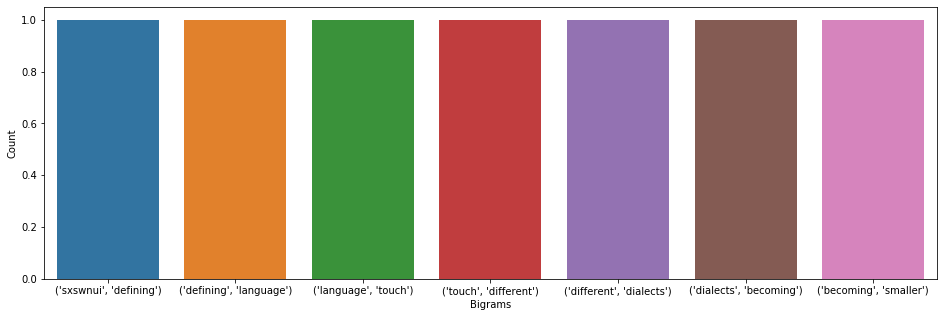

In [507]:
a = nltk.FreqDist(output)
d = pd.DataFrame({'Bigrams': list(a.keys()),
                  'Count': list(a.values())})
print(d)
#word_popular_df['bigram_word'] = word_popular_df.W1 + "  " + word_popular_df.W2

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Bigrams", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### 6.2 : Term Frequency 

#Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.
#Therefore, we can generalize term frequency as:

TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [ ]:
tf1 = (train2['clean_tweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

### 6.3: Inverse Document Frequency 

The intuition behind inverse document frequency (IDF) is that a word is not of much use to us if it’s appearing in all the documents.

Therefore, the IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

In [ ]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(train2.shape[0]/(len(train2[train2['clean_tweet'].str.contains(word)])))


In [ ]:
print(tf1)

#### Inference:
The more the value of IDF, the more unique is the word.

### 6.4 Term Frequency – Inverse Document Frequency (TF-IDF)



TF-IDF is the multiplication of the TF and IDF which we calculated above.

In [508]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,doodles,2,5.801019,11.602038
1,funny,1,5.896329,5.896329
2,occasions,1,8.892062,8.892062
3,significant,1,8.892062,8.892062
4,innovative,1,7.793449,7.793449
5,light,1,4.687369,4.687369
6,ab,1,2.787268,2.787268
7,googledoodle,1,6.184011,6.184011
8,learning,1,6.327112,6.327112
9,exceptions,1,8.892062,8.892062


In [509]:
#sklearn has a separate function to directly obtain it
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train2['clean_tweet'])

In [510]:
train_vect

<7274x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 36622 stored elements in Compressed Sparse Row format>

In [511]:
train_vect.shape

(7274, 1000)

### 6.5 : Bag of words :

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train2['clean_tweet'])
train_bow

### 6.6 Sentiment Analysis

If you recall, our problem was to detect the sentiment of the tweet. So, before applying any ML/DL models (which can have a separate feature detecting the sentiment using the textblob library), let’s check the sentiment of the first few tweets.

In [ ]:
train2['clean_tweet'][:5].apply(lambda x: TextBlob(x).sentiment)

Above, you can see that it returns a tuple representing polarity and subjectivity of each tweet. Here, we only extract polarity as it indicates the sentiment as value nearer to 1 means a positive sentiment and values nearer to -1 means a negative sentiment. This can also work as a feature for building a machine learning model.

In [ ]:
train2['sent_blob'] = train2['clean_tweet'].apply(lambda x: TextBlob(x).sentiment[0] )
train2[['clean_tweet','sent_blob','sentiment']].head()

## Step 7: Data Cleaning :

In [ ]:
train2_final=train2.copy()

### 7.1 Dropping one row where tweet has null value (tweet_id=6)

In [ ]:
train2_final.info()

In [ ]:
data_insights_report(train2_final)

In [ ]:
train2_final[train2_final.tweet_id==6]

In [ ]:
train2_final.shape

### 7.2 Handling Duplicate Records :

In [ ]:
dup_tweets=train2_final[train2_final['lem_clean_tweet'].duplicated()]

In [ ]:
len(dup_tweets)

In [ ]:
len(dup_tweets)

In [ ]:
len(set(dup_tweets))

### 7.3 deleting all records of sentiment can't say(3) from train dataset:

In [ ]:
train2_final=train2_final[train2_final.sentiment !=3]

In [ ]:
train2_final['sentiment'].unique()

In [ ]:
train2.shape

In [ ]:
train2_final.shape

In [ ]:
train3=train2_final.copy()

# Step 8 Count Vectorizer : bow & tfidf

### Bag Of Words : bow

In [512]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(train3['clean_tweet'])
bow.shape

(7274, 1000)

In [513]:
train_bow = bow

## Step 8: Splitting Train Data into train & test :

In [514]:
# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train3['sentiment'],  
                                                          random_state=42, 
                                                          test_size=0.3)

## Step 9: Baseline Model :

## Logistic Regression 

In [515]:
logreg = LogisticRegression()
logreg.fit(xtrain_bow, ytrain)
Y_pred = logreg.predict(xvalid_bow)
conf_matrix=confusion_matrix(yvalid, Y_pred)
acc_log = round(accuracy_score(yvalid, Y_pred) * 100, 2)
#prec_log= round(precision_score(yvalid, Y_pred) * 100, 2)
F1_log = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_log = round(recall_score(yvalid,Y_pred)*100,2)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [516]:
F1_log

62.57

## SVM :

In [517]:
from sklearn import svm

In [518]:
svc = svm.SVC()
svc.fit(xtrain_bow, ytrain)
Y_pred = svc.predict(xvalid_bow)
#acc_svc = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_svc=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_svc = round(f1_score(yvalid, Y_pred,average='weighted')*100,2)
#Recall_svc = round(recall_score(Y_test,Y_pred)*100,2)

In [519]:
F1_svc

62.47

## Random Forest 

In [520]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(xtrain_bow, ytrain)
Y_pred = random_forest.predict(xvalid_bow)
#random_forest.score(yvalid, Y_pred)
#acc_random_forest = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_random_forest=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_random_forest = round(f1_score(yvalid, Y_pred,average='weighted')*100,2)
#Recall_random_forest = round(recall_score(Y_test,Y_pred)*100,2)



In [521]:
F1_random_forest

62.66

## XGB classifier

In [524]:
from xgboost import XGBClassifier

In [525]:
##XGB classifier
model_xgb=XGBClassifier()
model_xgb.fit(xtrain_bow, ytrain)
pred_xgb=model_xgb.predict(xvalid_bow)
#acc_xgb = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_xgb=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_xgb = round(f1_score(yvalid, pred_xgb,average='weighted')*100,2)
#Recall_xgb = round(recall_score(Y_test,Y_pred)*100,2)

In [526]:
F1_xgb

57.28

## Adaboost classifier

In [527]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [528]:
##Adaboost classifier
model_ada=AdaBoostClassifier()
model_ada.fit(xtrain_bow, ytrain)
pred_ada=model_ada.predict(xvalid_bow)
#acc_ada = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_ada=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_ada = round(f1_score(yvalid,pred_ada,average='weighted')*100,2)
#Recall_ada = round(recall_score(Y_test,Y_pred)*100,2)

In [529]:
F1_ada

55.13

In [535]:
models = pd.DataFrame({
    'Model - BOW': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 
              'XGB','Adaboost','Linear SVC','Gaussian Naive Bayes'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[F1_svc,F1_log, F1_random_forest,
              F1_xgb,F1_ada,F1_linear_svc,F1_guassian]})
models.sort_values(by='F1', ascending=False)

,Model - BOW,F1
2,Random Forest,62.66
1,Logistic Regression,62.57
0,Support Vector Machines,62.47
5,Linear SVC,62.10
3,XGB,57.28
4,Adaboost,55.13
6,Gaussian Naive Bayes,37.91


In [531]:
# Linear SVC
from sklearn.svm import SVC, LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(xtrain_bow, ytrain)
Y_pred = linear_svc.predict(xvalid_bow)
#acc_linear_svc = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_linear_svc=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_linear_svc = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_linear_svc = round(recall_score(Y_test,Y_pred)*100,2)

In [532]:
F1_linear_svc

62.1

In [533]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(xtrain_bow.toarray(), ytrain)
Y_pred = gaussian.predict(xvalid_bow.toarray())
#acc_gaussian = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_guassian=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_guassian = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_guassian= round(recall_score(Y_test,Y_pred)*100,2)

In [534]:
F1_guassian

37.91

## SMOTE :

In [536]:
#SMOTE
sm = SMOTE()
sm_xtrain_bow, sm_train_y = sm.fit_sample(xtrain_bow,ytrain)

In [537]:
rf = RandomForestClassifier().fit(sm_xtrain_bow, sm_train_y)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction,average='weighted')

0.5682776456525735

In [538]:
logreg = LogisticRegression().fit(sm_xtrain_bow, sm_train_y)
#logreg.fit(xtrain_bow, ytrain)
prediction = logreg.predict(xvalid_bow)
f1_score(yvalid, prediction,average='weighted')

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5736283195737969

## TFIDF :

In [539]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf1 = tfidf_vectorizer.fit_transform(train3['clean_tweet'])
tfidf1.shape

(7274, 1000)

In [540]:
train_tfidf = tfidf1
#test_tfidf = tfidf

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]
xtrain_tfidf.shape

(5091, 1000)

In [541]:
logreg = LogisticRegression()
logreg.fit(xtrain_tfidf, ytrain)
Y_pred = logreg.predict(xvalid_tfidf)
#conf_matrix=confusion_matrix(yvalid, Y_pred)
#acc_log = round(accuracy_score(yvalid, Y_pred) * 100, 2)
#prec_log= round(precision_score(yvalid, Y_pred) * 100, 2)
F1_log = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_log = round(recall_score(yvalid,Y_pred)*100,2)

In [542]:
F1_log

61.47

In [543]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(xtrain_tfidf, ytrain)
Y_pred = random_forest.predict(xvalid_tfidf)
#random_forest.score(yvalid, Y_pred)
#acc_random_forest = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_random_forest=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_random_forest = round(f1_score(yvalid, Y_pred,average='weighted')*100,2)
#Recall_random_forest = round(recall_score(Y_test,Y_pred)*100,2)

In [544]:
F1_random_forest 

64.06

In [545]:
svc = svm.SVC()
svc.fit(xtrain_tfidf, ytrain)
Y_pred = svc.predict(xvalid_tfidf)
#acc_svc = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_svc=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_svc = round(f1_score(yvalid, Y_pred,average='weighted')*100,2)
#Recall_svc = round(recall_score(Y_test,Y_pred)*100,2)

In [546]:
F1_svc

62.8

In [547]:
##XGB classifier
model_xgb=XGBClassifier()
model_xgb.fit(xtrain_tfidf, ytrain)
pred_xgb=model_xgb.predict(xvalid_tfidf)
#acc_xgb = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_xgb=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_xgb = round(f1_score(yvalid, pred_xgb,average='weighted')*100,2)
#Recall_xgb = round(recall_score(Y_test,Y_pred)*100,2)

In [548]:
F1_xgb

56.75

In [549]:
##Adaboost classifier
model_ada=AdaBoostClassifier()
model_ada.fit(xtrain_tfidf, ytrain)
pred_ada=model_ada.predict(xvalid_tfidf)
#acc_ada = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_ada=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_ada = round(f1_score(yvalid,pred_ada,average='weighted')*100,2)
#Recall_ada = round(recall_score(Y_test,Y_pred)*100,2)

In [550]:
F1_ada

53.27

In [557]:
models = pd.DataFrame({
    'Model - TFIDF': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 
              'XGB','Adaboost','Linear SVC','Gaussian Naive Bayes'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[F1_svc,F1_log, F1_random_forest,
              F1_xgb,F1_ada,F1_linear_svc,F1_guassian]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF,F1
2,Random Forest,64.06
0,Support Vector Machines,62.80
5,Linear SVC,62.50
1,Logistic Regression,61.47
3,XGB,56.75
4,Adaboost,53.27
6,Gaussian Naive Bayes,38.51


In [552]:
# Linear SVC
from sklearn.svm import SVC, LinearSVC
linear_svc = LinearSVC()
linear_svc.fit(xtrain_tfidf, ytrain)
Y_pred = linear_svc.predict(xvalid_tfidf)
#acc_linear_svc = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_linear_svc=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_linear_svc = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_linear_svc = round(recall_score(Y_test,Y_pred)*100,2)

In [553]:
F1_linear_svc

62.5

In [554]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(xtrain_tfidf.toarray(), ytrain)
Y_pred = gaussian.predict(xvalid_tfidf.toarray())
#acc_gaussian = round(accuracy_score(Y_test, Y_pred) * 100, 2)
#prec_guassian=round(precision_score(Y_test, Y_pred) * 100, 2)
F1_guassian = round(f1_score(yvalid,Y_pred,average='weighted')*100,2)
#Recall_guassian= round(recall_score(Y_test,Y_pred)*100,2)

In [555]:
F1_guassian

38.51

## Using SMOTE :

In [558]:
#SMOTE
sm = SMOTE()
sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf,ytrain)

In [559]:
rf = RandomForestClassifier().fit(sm_xtrain_tfidf, sm_train_y)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction,average='weighted')

0.5827544654298359

In [561]:
logreg = LogisticRegression().fit(sm_xtrain_tfidf, sm_train_y)
#logreg.fit(xtrain_bow, ytrain)
prediction = logreg.predict(xvalid_tfidf)
f1_score(yvalid, prediction,average='weighted')

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5571396106281521

In [562]:
F1_linear_svc

62.5

In [ ]:
test_pred_lf = logreg.predict(test_tfidf)

In [ ]:
test_pred_rf = random_forest.predict(test_tfidf)

In [ ]:
len(test_pred_rf)

In [ ]:
sub_csv = pd.read_csv('/Users/shilpyjain/Downloads/data/sample_submission.csv')

In [ ]:
sub_csv['sentiment']=test_pred_rf

In [ ]:
sub_csv.to_csv('result6.csv',index=False)

## Test Dataset :

In [ ]:
test=pd.read_csv("/Users/shilpyjain/Downloads/data/test.csv")

In [ ]:
test.shape

In [ ]:
test.info()

In [ ]:
data_insights_report(test)

In [ ]:
test2=test.copy()

In [ ]:
#Transforming Emoticons into "happy" & "sad" :
test['tweet']=test['tweet'].map(lambda x: replace_emoji(str(x)))
#Removal of puncuations :
test['clean_tweet'] = test['tweet'].str.replace('[^\w\s]','')
#Removal of Stop words :
stop = stopwords.words('english')
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#Removal of frequent words:
freq = pd.Series(' '.join(test['clean_tweet']).split()).value_counts()[:10]
freq = list(freq.index)
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#Removal of rare words :
freq2 = pd.Series(' '.join(test['clean_tweet']).split()).value_counts()[-10:]
freq2 = list(freq2.index)
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq2))
#replace consecutive non-ASCII characters with a space
test['clean_tweet'] =test['clean_tweet'].str.replace('[^\x00-\x7F]+',' ')

In [ ]:
test.info()

In [ ]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow2 = bow_vectorizer.fit_transform(test['clean_tweet'])
bow2.shape

In [ ]:
test_bow = bow2

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf2 = tfidf_vectorizer.fit_transform(test['clean_tweet'])
tfidf2.shape

In [ ]:
test_tfidf = tfidf2

## Treating data imbalance :

In [563]:
#import the necessary libraries for dataset preparation, feature engineering, model training
from sklearn import model_selection, preprocessing, metrics, linear_model, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
import pandas as pd, numpy, string
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
#Remove Special Charactors
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [564]:
#split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train3['clean_tweet'],train3['sentiment'])
#label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [565]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(train3['clean_tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [567]:
#Return the f1 Score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    return metrics.f1_score(valid_y,predictions,average='weighted')

In [568]:
#Let us see the baseline result (without re-sampling):
accuracy_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", round(accuracy_LR,2))
accuracy_linear_SVM = train_model(svm.LinearSVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", round(accuracy_linear_SVM,2))
accuracy_RF = train_model(RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("Random Forest, WordLevel TFIDF: ", round(accuracy_RF,2))
#LR Baseline, WordLevel TFIDF:  0.534131736526946
#SVM Baseline, WordLevel TFIDF:  0.6991701244813279

LR Baseline, WordLevel TFIDF:  0.62
SVM Baseline, WordLevel TFIDF:  0.63
Random Forest, WordLevel TFIDF:  0.61


In [569]:
models = pd.DataFrame({
    'Model - TFIDF (without resampling)': ['Linear Support Vector Machines', 'Logistic Regression', 
              'Random Forest'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[round(accuracy_linear_SVM,2),round(accuracy_LR,2),
              round(accuracy_RF,2)]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF (without resampling),F1
0,Linear Support Vector Machines,0.63
1,Logistic Regression,0.62
2,Random Forest,0.61


### Re-sampling the Training Corpus


### Random Over-sampling

#The below code block uses Scikit learn over-sampling method to randomly repeat some minority samples and balance the number of samples between the data-set.


In [570]:
#Random Over Sampling
ros = RandomOverSampler(random_state=777)
ros_xtrain_tfidf, ros_train_y = ros.fit_sample(xtrain_tfidf, train_y)
accuracy_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),ros_xtrain_tfidf, ros_train_y , xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", round(accuracy_LR,2))
accuracy_linear_SVM = train_model(svm.LinearSVC(), ros_xtrain_tfidf, ros_train_y , xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", round(accuracy_linear_SVM,2))
accuracy_RF = train_model(RandomForestClassifier(), ros_xtrain_tfidf, ros_train_y , xvalid_tfidf)
print ("Random Forest, WordLevel TFIDF: ", round(accuracy_RF,2))

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Baseline, WordLevel TFIDF:  0.64
SVM Baseline, WordLevel TFIDF:  0.64
Random Forest, WordLevel TFIDF:  0.63


In [571]:
models = pd.DataFrame({
    'Model - TFIDF (with resampling)': ['Linear Support Vector Machines', 'Logistic Regression', 
              'Random Forest'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[round(accuracy_linear_SVM,2),round(accuracy_LR,2),
              round(accuracy_RF,2)]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF (with resampling),F1
0,Linear Support Vector Machines,0.64
1,Logistic Regression,0.64
2,Random Forest,0.63


In [572]:
test_tfidf

<1819x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 10518 stored elements in Compressed Sparse Row format>

In [573]:
test_tfidf.shape

(1819, 1000)

### SMOTE Over-sampling

In [574]:
#SMOTE
sm = SMOTE()
sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf, train_y)
accuracy_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),sm_xtrain_tfidf, sm_train_y, xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", accuracy_LR)
accuracy_linear_SVM = train_model(svm.LinearSVC(), sm_xtrain_tfidf, sm_train_y , xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", accuracy_linear_SVM)
accuracy_RF = train_model(RandomForestClassifier(), sm_xtrain_tfidf, sm_train_y , xvalid_tfidf)
print ("Random Forest, WordLevel TFIDF: ", accuracy_RF)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Baseline, WordLevel TFIDF:  0.6334530735064163
SVM Baseline, WordLevel TFIDF:  0.6405127440156484
Random Forest, WordLevel TFIDF:  0.6271268824277072


In [575]:
models = pd.DataFrame({
    'Model - TFIDF (SMOTE Over-sampling)': ['Linear Support Vector Machines', 'Logistic Regression', 
              'Random Forest'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[accuracy_linear_SVM,accuracy_LR,
              accuracy_RF]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF (SMOTE Over-sampling),F1
0,Linear Support Vector Machines,0.640513
1,Logistic Regression,0.633453
2,Random Forest,0.627127


### ADASYN: Adaptive synthetic sampling (Over-sampling)

In [578]:
#ADASYN
ad = ADASYN(random_state=777)
ad_xtrain_tfidf, ad_train_y = ad.fit_sample(xtrain_tfidf, train_y)
accuracy_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),ad_xtrain_tfidf, ad_train_y, xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", accuracy_LR)
accuracy_linear_SVM = train_model(svm.LinearSVC(), ad_xtrain_tfidf, ad_train_y , xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", accuracy_linear_SVM)
accuracy_RF = train_model(RandomForestClassifier(), ad_xtrain_tfidf, ad_train_y , xvalid_tfidf)
print ("Random Forest, WordLevel TFIDF: ", accuracy_RF)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Baseline, WordLevel TFIDF:  0.6324442851923807
SVM Baseline, WordLevel TFIDF:  0.6331759161685486
Random Forest, WordLevel TFIDF:  0.6258460021040921


In [579]:
models = pd.DataFrame({
    'Model - TFIDF ADASYN(over sampling)': ['Linear Support Vector Machines', 'Logistic Regression', 
              'Random Forest'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[accuracy_linear_SVM,accuracy_LR,
              accuracy_RF]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF ADASYN(over sampling),F1
0,Linear Support Vector Machines,0.633176
1,Logistic Regression,0.632444
2,Random Forest,0.625846


### SMOTENC

In [580]:
smnc = SMOTENC(categorical_features=[0, 2], random_state=0)
smnc_xtrain_tfidf, smnc_train_y = smnc.fit_sample(xtrain_tfidf, train_y)
accuracySMOTENC = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),smnc_xtrain_tfidf, smnc_train_y, xvalid_tfidf)
print ("LR SMOTENC, WordLevel TFIDF: ", accuracySMOTENC)
accuracySMOTENC = train_model(svm.LinearSVC(),smnc_xtrain_tfidf, smnc_train_y, xvalid_tfidf)
print ("SVM SMOTENC, WordLevel TFIDF: ", accuracySMOTENC)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR SMOTENC, WordLevel TFIDF:  0.6290027504630135
SVM SMOTENC, WordLevel TFIDF:  0.6428006429975838


### Borderline SMOTE

In [581]:
bsm = BorderlineSMOTE()
bsm_xtrain_tfidf, bsm_train_y = bsm.fit_sample(xtrain_tfidf, train_y)
accuracyBSMOTE = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),bsm_xtrain_tfidf, bsm_train_y, xvalid_tfidf)
print ("LR Borderline SMOTE, WordLevel TFIDF: ", accuracyBSMOTE)
accuracyBSMOTE = train_model(svm.LinearSVC(),bsm_xtrain_tfidf, bsm_train_y, xvalid_tfidf)
print ("SVM Borderline SMOTE, WordLevel TFIDF: ", accuracyBSMOTE)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Borderline SMOTE, WordLevel TFIDF:  0.6344128486074709
SVM Borderline SMOTE, WordLevel TFIDF:  0.6379210569576995


## Random Under-sampling

In [582]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=0, replacement=True)
rus_xtrain_tfidf, rus_train_y = rus.fit_sample(xtrain_tfidf, train_y)
accuracy_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),rus_xtrain_tfidf, rus_train_y, xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", accuracy_LR)
accuracy_linear_SVM = train_model(svm.LinearSVC(), rus_xtrain_tfidf, rus_train_y, xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", accuracy_linear_SVM)
accuracy_RF = train_model(RandomForestClassifier(), rus_xtrain_tfidf, rus_train_y , xvalid_tfidf)
print ("Random Forest, WordLevel TFIDF: ", accuracy_RF)

LR Baseline, WordLevel TFIDF:  0.42086609057320457
SVM Baseline, WordLevel TFIDF:  0.42674344301656286
Random Forest, WordLevel TFIDF:  0.4161957580699035


In [583]:
models = pd.DataFrame({
    'Model - TFIDF (Random Under-sampling)': ['Linear Support Vector Machines', 'Logistic Regression', 
              'Random Forest'],
    #'Acc_Score': [acc_svc, acc_knn, acc_log, 
              #acc_random_forest, acc_gaussian, acc_perceptron, 
              #acc_sgd, acc_linear_svc, acc_decision_tree,acc_kfold_rf,acc_Voting_class,acc_xgb,acc_ada],
    #'Precision':[prec_svc, prec_knn, prec_log, 
              #prec_random_forest, prec_guassian, prec_perceptron, 
              #prec_sgd, prec_linear_svc, prec_decision_tree,prec_kfold_rf,prec_Voting_class,prec_xgb,prec_ada],
    #'Recall':[Recall_svc, Recall_knn, Recall_log, 
              #Recall_random_forest, Recall_guassian, Recall_perceptron, 
             # Recall_sgd, Recall_linear_svc, Recall_decision_tree,Recall_kfold_rf,Recall_Voting_class,Recall_xgb,Recall_ada],
    'F1':[accuracy_linear_SVM,accuracy_LR,
              accuracy_RF]})
models.sort_values(by='F1', ascending=False)

,Model - TFIDF (Random Under-sampling),F1
0,Linear Support Vector Machines,0.426743
1,Logistic Regression,0.420866
2,Random Forest,0.416196


In [584]:
#NearMiss
for sampler in (NearMiss(version=1),NearMiss(version=2),NearMiss(version=3)):
    nm_xtrain_tfidf, nm_train_y = sampler.fit_sample(xtrain_tfidf, train_y)
    accuracysm = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),nm_xtrain_tfidf, nm_train_y, xvalid_tfidf)
    print ("LR NearMiss(version= {0}), WordLevel TFIDF: ".format(sampler.version), accuracysm)

for sampler in (NearMiss(version=1),NearMiss(version=2),NearMiss(version=3)):
    nm_xtrain_tfidf, nm_train_y = sampler.fit_sample(xtrain_tfidf, train_y)
    accuracysm = train_model(svm.LinearSVC(),nm_xtrain_tfidf, nm_train_y, xvalid_tfidf)
    print ("SVC NearMiss(version= {0}), WordLevel TFIDF: ".format(sampler.version), accuracysm)


LR NearMiss(version= 1), WordLevel TFIDF:  0.2042904067879488
LR NearMiss(version= 2), WordLevel TFIDF:  0.42860060877541567
LR NearMiss(version= 3), WordLevel TFIDF:  0.3897130796901676
SVC NearMiss(version= 1), WordLevel TFIDF:  0.284361558920669
SVC NearMiss(version= 2), WordLevel TFIDF:  0.42417108611407756
SVC NearMiss(version= 3), WordLevel TFIDF:  0.39762955417109686


In [585]:
# Under-Sampling TomekLinks
tl = TomekLinks()
tl_xtrain_tfidf, tl_train_y = tl.fit_sample(xtrain_tfidf, train_y)
accuracy = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),tl_xtrain_tfidf, tl_train_y, xvalid_tfidf)
print ("LR TomekLinks, WordLevel TFIDF: ", accuracy)
accuracy = train_model(svm.LinearSVC(),tl_xtrain_tfidf, tl_train_y, xvalid_tfidf)
print ("SVC TomekLinks, WordLevel TFIDF: ", accuracy)

LR TomekLinks, WordLevel TFIDF:  0.6112946168882363
SVC TomekLinks, WordLevel TFIDF:  0.639405344690947
